In [1]:
from collections import OrderedDict

import uproot
import numpy as np
import matplotlib.pyplot as plt

import hist
from hist import Hist

import plotting
from hh_vars import data_key
from postprocessing import nonres_shape_vars, get_nonres_selection_regions

import os

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
MAIN_DIR = "../../../"

plot_dir = "../../../plots/PostFit/23Nov7NonresAsimov"
_ = os.system(f"mkdir -p {plot_dir}")

In [17]:
cards_dir = "23May16RemFeats/rem_feats_3/"
asimov = True

asimov_label = "Asimov" if asimov else ""
file = uproot.open(
    f"/uscms/home/rkansal/hhcombine/cards/{cards_dir}/FitShapes{asimov_label}.root"
    # f"/uscms/home/rkansal/eos/bbVV/cards/{cards_dir}/FitShapes.root"
)

In [11]:
fdfile = uproot.open(
    f"/uscms/home/rkansal/hhcombine/cards/{cards_dir}/higgsCombineAsimov.FitDiagnostics.mH125.root"
)

[]

In [10]:
file.keys()

['fail_prefit;1',
 'fail_prefit/TotalBkg;1',
 'fail_prefit/TotalProcs;1',
 'fail_prefit/TotalSig;1',
 'fail_prefit/bbWW_boosted_ggf_qcd_datadriven;1',
 'fail_prefit/data_obs;1',
 'fail_prefit/singletop;1',
 'fail_prefit/ttbar;1',
 'fail_prefit/vjets;1',
 'failBlinded_prefit;1',
 'failBlinded_prefit/TotalBkg;1',
 'failBlinded_prefit/TotalProcs;1',
 'failBlinded_prefit/TotalSig;1',
 'failBlinded_prefit/bbWW_boosted_ggf_qcd_datadriven;1',
 'failBlinded_prefit/data_obs;1',
 'failBlinded_prefit/singletop;1',
 'failBlinded_prefit/ttbar;1',
 'failBlinded_prefit/vjets;1',
 'pass_prefit;1',
 'pass_prefit/TotalBkg;1',
 'pass_prefit/TotalProcs;1',
 'pass_prefit/TotalSig;1',
 'pass_prefit/bbWW_boosted_ggf_qcd_datadriven;1',
 'pass_prefit/data_obs;1',
 'pass_prefit/ggHH_kl_1_kt_1_hbbhww4q;1',
 'pass_prefit/ttbar;1',
 'pass_prefit/vjets;1',
 'passBlinded_prefit;1',
 'passBlinded_prefit/TotalBkg;1',
 'passBlinded_prefit/TotalProcs;1',
 'passBlinded_prefit/TotalSig;1',
 'passBlinded_prefit/bbWW_booste

In [21]:
workspace_data_key = "data_obs"  # if not asimov else "toy_asimov"

# (name in templates, name in cards)
hist_label_map_inverse = OrderedDict(
    [
        ("QCD", "bbWW_boosted_ggf_qcd_datadriven"),
        # ("Diboson", "diboson"),
        ("TT", "ttbar"),
        ("ST", "singletop"),
        ("V+Jets", "vjets"),
        # ("X[3000]->H(bb)Y[190](VV)", "xhy_mx3000_my190"),
        ("HHbbVV", "ggHH_kl_1_kt_1_hbbhww4q"),
        (data_key, workspace_data_key),
    ]
)

hist_label_map = {val: key for key, val in hist_label_map_inverse.items()}
samples = list(hist_label_map.values())

In [22]:
shapes = {
    "prefit": "Pre-Fit",
    # "shapes_fit_s": "S+B Post-Fit",
    "postfit": "B-only Post-Fit",
}

shape_vars = nonres_shape_vars

selection_regions = {
    "pass": "Pass",
    "fail": "Fail",
}

In [23]:
hists = {}

for shape in shapes:
    print(shape)
    hists[shape] = {
        region: Hist(
            hist.axis.StrCategory(samples, name="Sample"),
            *[shape_var.axis for shape_var in shape_vars],
            storage="double",
        )
        for region in selection_regions
    }

    for region in selection_regions:
        h = hists[shape][region]
        templates = file[f"{region}_{shape}"]
        for key, file_key in hist_label_map_inverse.items():
            if key != data_key:
                if file_key not in templates:
                    print(f"No {key} in {region}")
                    continue

                data_key_index = np.where(np.array(list(h.axes[0])) == key)[0][0]
                h.view(flow=False)[data_key_index, :] = templates[file_key].values()

        data_key_index = np.where(np.array(list(h.axes[0])) == data_key)[0][0]
        h.view(flow=False)[data_key_index, :] = np.nan_to_num(
            templates[hist_label_map_inverse[data_key]].values()
        )

prefit
No ST in pass
No HHbbVV in fail
postfit
No ST in pass
No HHbbVV in fail


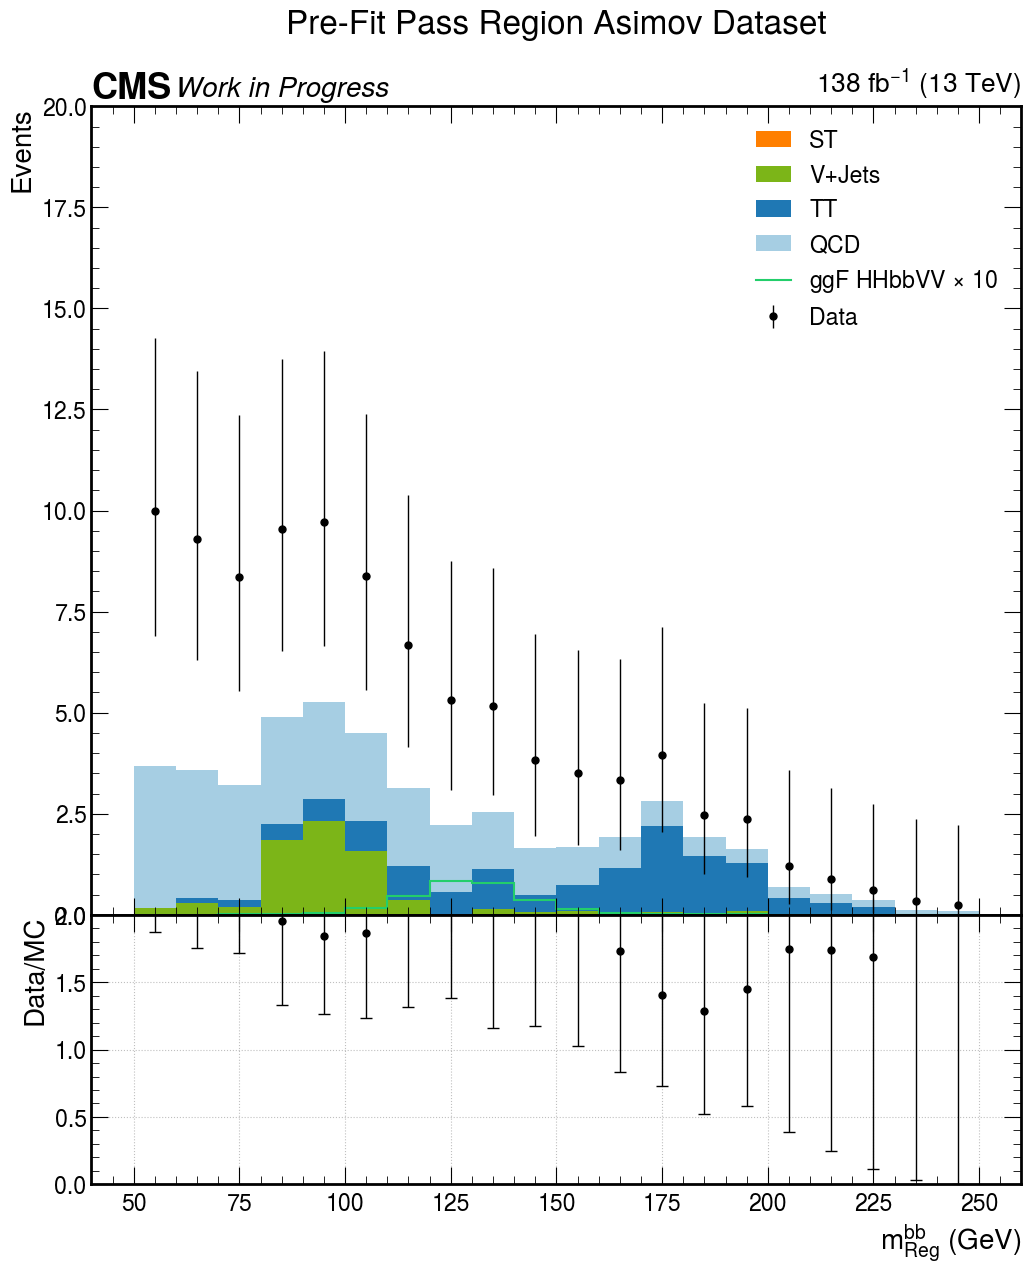

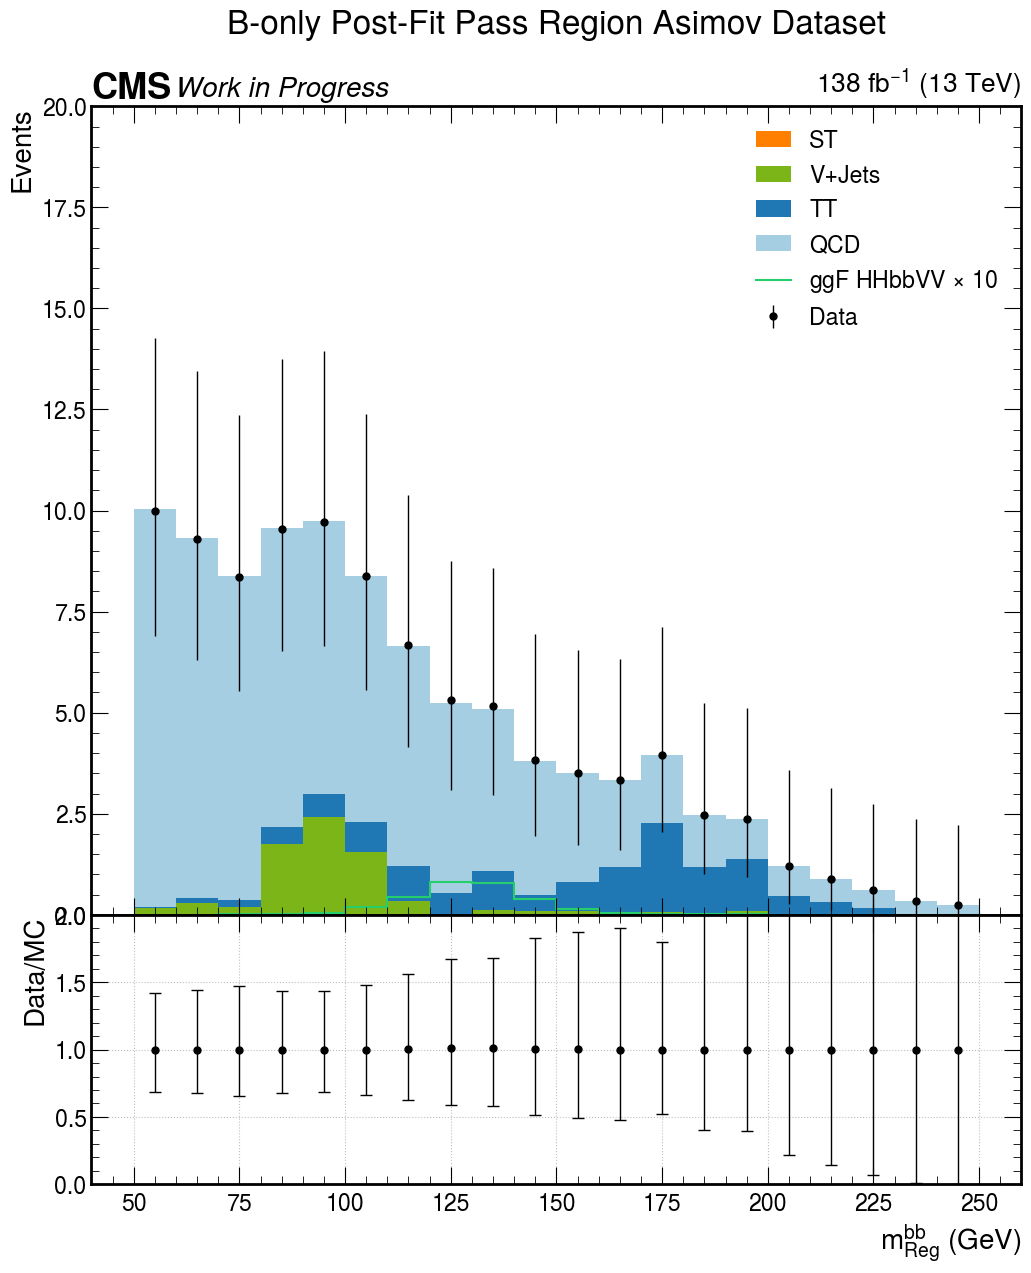

In [25]:
pass_ylim = 20
fail_ylim = 600000
for shape, shape_label in shapes.items():
    for region, region_label in selection_regions.items():
        pass_region = region.startswith("pass")
        for i, shape_var in enumerate(shape_vars):
            plot_params = {
                "hists": hists[shape][region],
                "sig_keys": [f"HHbbVV"],
                "bg_keys": ["QCD", "V+Jets", "TT", "ST"],
                "sig_scale_dict": {"HHbbVV": 10},
                "show": True,
                "year": "all",
                "ylim": pass_ylim if pass_region else fail_ylim,
                "title": f"{shape_label} {region_label} Region Asimov Dataset",
                "name": f"{plot_dir}/{shape}_{region}_{shape_var.var}.pdf",
            }

            plotting.ratioHistPlot(**plot_params, data_err=True)

        break
    break